In [1]:
import warnings
warnings.simplefilter('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

%matplotlib inline
plt.rc('font', family='Verdana')

C:\Users\makar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# увеличиваем количество выводимых столбцов
pd.set_option('display.max_columns', 11)

In [3]:
data = pd.read_csv("C:/test_train.csv", encoding='cp1251', sep = ';')
# выводим первые 5 наблюдений
data.head()

,agreement,group,credit_rating,customer_scores,status,overdue_time,region,summary,sex,birthday,age
0,2502412016,3,C,380,Просрочен,164,Новосибирск,5000,Женский,03.09.1962,56
1,8190112016,14,F+,-115,Просрочен,160,Красноярск,3000,Мужской,14.01.1992,26
2,8172212016,13,E,80,Просрочен,160,Красноярск,3000,Мужской,10.10.1982,36
3,2492412016,3,B,560,Просрочен,160,Новосибирск,4000,Женский,13.03.1981,37
4,2493412016,3,C,320,Просрочен,160,Новосибирск,5000,Мужской,16.07.1985,33


In [4]:
# выводим информацию о количестве непропущенных 
# наблюдений в переменных и типах переменных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
agreement          1218 non-null int64
group              1218 non-null int64
credit_rating      1218 non-null object
customer_scores    1218 non-null int64
status             1218 non-null object
overdue_time       1218 non-null int64
region             1218 non-null object
summary            1218 non-null int64
sex                1218 non-null object
birthday           1218 non-null object
age                1218 non-null int64
dtypes: int64(6), object(5)
memory usage: 104.8+ KB


In [5]:
#Присваиваем характеристикам тип объект для их представления ввиде категорий
for i in ['group','summary']:
    if i in data.columns:
        data[i] = data[i].astype('object')

In [6]:
#удаляем номер договора так как он уникален и дату рождения, вместо неё есть параметр возраст
data = data.drop(["birthday"], axis = 1)
data['status'] = data.status.apply(lambda _: 0 if _ == u'Просрочен' else 1)

In [7]:
#смотрим unique - количество уникальных значений,
data['summary'].describe()

count     1218
unique       9
top       5000
freq       403
Name: summary, dtype: int64

In [8]:
data.head()

,agreement,group,credit_rating,customer_scores,status,overdue_time,region,summary,sex,age
0,2502412016,3,C,380,0,164,Новосибирск,5000,Женский,56
1,8190112016,14,F+,-115,0,160,Красноярск,3000,Мужской,26
2,8172212016,13,E,80,0,160,Красноярск,3000,Мужской,36
3,2492412016,3,B,560,0,160,Новосибирск,4000,Женский,37
4,2493412016,3,C,320,0,160,Новосибирск,5000,Мужской,33


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 10 columns):
agreement          1218 non-null int64
group              1218 non-null object
credit_rating      1218 non-null object
customer_scores    1218 non-null int64
status             1218 non-null int64
overdue_time       1218 non-null int64
region             1218 non-null object
summary            1218 non-null object
sex                1218 non-null object
age                1218 non-null int64
dtypes: int64(5), object(5)
memory usage: 95.2+ KB


In [10]:
#избавляемся от лишнего статуса "Активный"
new_data = data[data.credit_rating !='0']

In [11]:
new_data['status'].describe()

count    1208.000000
mean        0.743377
std         0.436950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: status, dtype: float64

In [12]:
trg = new_data['status']

In [13]:
#Удаляем значения overdue_time так как у нас не будет этих данных при предполагаемой оценке клиента
trn = new_data

In [14]:
#Задаём точки границ категории возраст
bins_age_cat = [-np.inf, 30, 38, 55, 60,  np.inf]
#Осуществляем биннинг переменной age и записываем результаты в новую переменную
trn['age_cat'] = pd.cut(trn['age'], bins_age_cat)
#Удаляем age
trn = trn.drop(['age'], axis = 1)

In [15]:
bins_cat_customer_scores = [-np.inf, 190, 390, 710, np.inf]
trn['cat_customer_scores'] = pd.cut(trn['customer_scores'], bins_cat_customer_scores)
trn = trn.drop(['customer_scores'], axis = 1)

In [16]:
# строим таблицу сопряженности age_cat * status
biv_age_cat = pd.crosstab(trn['age_cat'], trn['status'])
biv_age_cat

status,0,1
age_cat,,
"(-inf, 30.0]",120,210
"(30.0, 38.0]",81,197
"(38.0, 55.0]",65,240
"(55.0, 60.0]",19,89
"(60.0, inf]",25,162


In [17]:
# вычисляем WoE для каждой категории переменной age_cat, 
# при этом используем умножение на 1.0,
# чтобы преобразовать во float и добавляем "a=0.0001", 
# чтобы избежать деления на 0
a= 0.0001
WoE_age_cat = np.log((1.0*biv_age_cat[0]/sum(biv_age_cat[0])+a) / (1.0*biv_age_cat[1]/sum(biv_age_cat[1])+a))
WoE_age_cat

age_cat
(-inf, 30.0]    0.503813
(30.0, 38.0]    0.174770
(38.0, 55.0]   -0.242551
(55.0, 60.0]   -0.479978
(60.0, inf]    -0.804438
dtype: float64

In [18]:
# вычисляем IV для каждой категории переменной age_cat, 
# при этом используем умножение на 1.0,
# чтобы преобразовать во float и добавляем "a=0.0001", 
# чтобы избежать деления на 0
IV_age_cat=((1.0*biv_age_cat[0]/sum(biv_age_cat[0])+a) - 
          (1.0*biv_age_cat[1]/sum(biv_age_cat[1])+a))*np.log((1.0*biv_age_cat[0]/sum(biv_age_cat[0])+a) 
                                                  / (1.0*biv_age_cat[1]/sum(biv_age_cat[1])+a))
IV_age_cat

age_cat
(-inf, 30.0]    0.077206
(30.0, 38.0]    0.007325
(38.0, 55.0]    0.013967
(55.0, 60.0]    0.018152
(60.0, inf]     0.080247
dtype: float64

In [19]:
# вычисляем итоговое IV для переменной age_cat
# средняя прогностическая способность
IV = sum(((1.0*biv_age_cat[0]/sum(biv_age_cat[0])+a) - 
          (1.0*biv_age_cat[1]/sum(biv_age_cat[1])+a))*np.log((1.0*biv_age_cat[0]/sum(biv_age_cat[0])+a) 
                                                  / (1.0*biv_age_cat[1]/sum(biv_age_cat[1])+a)))
IV

0.19689778732046648

In [20]:
# пишем функцию, вычисляющую IV
# по всем предикторам
def auto_IV(df): 
    iv_list = [] 
    a= 0.0001
    data_drop = data.drop("status", axis=1) 
    for var_name in data_drop: 
        biv = pd.crosstab(df[var_name],data["status"])        
        IV = sum(((1.0*biv[0]/sum(biv[0])+a) - (1.0*biv[1]/sum(biv[1])+a))*
                 np.log((1.0*biv[0]/sum(biv[0])+a) / (1.0*biv[1]/sum(biv[1])+a)))
        iv_list.append(IV)
    col_list =list(data_drop)
    results = pd.DataFrame({'Название переменной' : col_list,'IV' : iv_list})
    results['Полезность'] = ['Подозрительно высокая' if x > 0.5 else 'Сильная' 
                             if x <= 0.5 and x > 0.3 else 'Средняя'
                             if x <= 0.3 and x > 0.1 else 'Слабая' 
                             if x <= 0.1 and x > 0.02 else 'Бесполезная' 
                             for x in results['IV']]  # по Наиму Сиддики
    return(results.sort_values(by = 'IV', ascending = False))

In [21]:
auto_IV(new_data)

,IV,Название переменной,Полезность
4,12.456770,overdue_time,Подозрительно высокая
0,6.013560,agreement,Подозрительно высокая
3,0.979574,customer_scores,Подозрительно высокая
8,0.527137,age,Подозрительно высокая
5,0.443753,region,Сильная
1,0.252207,group,Средняя
6,0.187462,summary,Средняя
2,0.178344,credit_rating,Средняя
7,0.030272,sex,Слабая


In [21]:
# строим таблицу сопряженности cat_customer_scores * status
biv_cat_customer_scores = pd.crosstab(trn['cat_customer_scores'], trn['status'])
biv_cat_customer_scores

status,0,1
cat_customer_scores,,
"(-inf, 190.0]",108,206
"(190.0, 390.0]",89,213
"(390.0, 710.0]",74,242
"(710.0, inf]",39,237


In [22]:
# вычисляем WoE для каждой категории переменной cat_customer_scores, 
# при этом используем умножение на 1.0,
# чтобы преобразовать во float и добавляем "a=0.0001", 
# чтобы избежать деления на 0
a= 0.0001
WoE_cat_customer_scores = np.log((1.0*biv_cat_customer_scores[0]/sum(biv_cat_customer_scores[0])+a) /
                                 (1.0*biv_cat_customer_scores[1]/sum(biv_cat_customer_scores[1])+a))
WoE_cat_customer_scores

cat_customer_scores
(-inf, 190.0]     0.417704
(190.0, 390.0]    0.190869
(390.0, 710.0]   -0.121227
(710.0, inf]     -0.740485
dtype: float64

In [23]:
# вычисляем IV для каждой категории переменной cat_customer_scores, 
# при этом используем умножение на 1.0,
# чтобы преобразовать во float и добавляем "a=0.0001", 
# чтобы избежать деления на 0
IV_cat_customer_scores=((1.0*biv_cat_customer_scores[0]/sum(biv_cat_customer_scores[0])+a) - 
          (1.0*biv_cat_customer_scores[1]/
           sum(biv_cat_customer_scores[1])+a))*np.log((1.0*biv_cat_customer_scores[0]/sum(biv_cat_customer_scores[0])+a) 
                                                                                     / (1.0*biv_cat_customer_scores[1]/sum(biv_cat_customer_scores[1])+a))
IV_cat_customer_scores

cat_customer_scores
(-inf, 190.0]     0.049702
(190.0, 390.0]    0.009525
(390.0, 710.0]    0.003731
(710.0, inf]      0.102271
dtype: float64

In [24]:
# вычисляем IV для каждой категории переменной cat_customer_scores, 
# при этом используем умножение на 1.0,
# чтобы преобразовать во float и добавляем "a=0.0001", 
# чтобы избежать деления на 0
IV_cat_customer_scores=sum(((1.0*biv_cat_customer_scores[0]/sum(biv_cat_customer_scores[0])+a) - 
          (1.0*biv_cat_customer_scores[1]/
           sum(biv_cat_customer_scores[1])+a))*np.log((1.0*biv_cat_customer_scores[0]/sum(biv_cat_customer_scores[0])+a) 
                                                                                     / (1.0*biv_cat_customer_scores[1]/sum(biv_cat_customer_scores[1])+a)))
IV_cat_customer_scores

0.1652288813808465

In [25]:
#Удаляем значения overdue_time так как у нас не будет этих данных при предполагаемой оценке клиента
#Так же удаляем номера договоров т.к. это уникальное значение
trn = trn.drop(['status', 'overdue_time','agreement'], axis=1)

In [26]:
trn.head()

,group,credit_rating,region,summary,sex,age_cat,cat_customer_scores
0,3,C,Новосибирск,5000,Женский,"(55.0, 60.0]","(190.0, 390.0]"
1,14,F+,Красноярск,3000,Мужской,"(-inf, 30.0]","(-inf, 190.0]"
2,13,E,Красноярск,3000,Мужской,"(30.0, 38.0]","(-inf, 190.0]"
3,3,B,Новосибирск,4000,Женский,"(30.0, 38.0]","(390.0, 710.0]"
4,3,C,Новосибирск,5000,Мужской,"(30.0, 38.0]","(190.0, 390.0]"


In [27]:
#Дамми-кодирование, получаем разряженные данные по каждой характеристике
print("Исходные переменные:\n", list(trn.columns), "\n")
trn_dummies = pd.get_dummies(trn)
print("Переменные после get_dummies:\n", list(trn_dummies.columns))

Исходные переменные:
 ['group', 'credit_rating', 'region', 'summary', 'sex', 'age_cat', 'cat_customer_scores'] 

Переменные после get_dummies:
 ['group_1', 'group_3', 'group_7', 'group_10', 'group_12', 'group_13', 'group_14', 'group_15', 'group_20', 'group_25', 'group_26', 'credit_rating_A', 'credit_rating_B', 'credit_rating_C', 'credit_rating_D', 'credit_rating_E', 'credit_rating_F+', 'region_Абакан', 'region_Ачинск', 'region_Казань', 'region_Канск', 'region_Красноярск', 'region_Назарово', 'region_Новосибирск', 'region_Норильск', 'region_Саяногорск', 'summary_2000', 'summary_3000', 'summary_4000', 'summary_5000', 'summary_6000', 'summary_7000', 'summary_8000', 'summary_9000', 'summary_10000', 'sex_Женский', 'sex_Мужской', 'age_cat_(-inf, 30.0]', 'age_cat_(30.0, 38.0]', 'age_cat_(38.0, 55.0]', 'age_cat_(55.0, 60.0]', 'age_cat_(60.0, inf]', 'cat_customer_scores_(-inf, 190.0]', 'cat_customer_scores_(190.0, 390.0]', 'cat_customer_scores_(390.0, 710.0]', 'cat_customer_scores_(710.0, inf]']

In [28]:
#Разбиваем данные на обучающую и контрольную выборки
X_train, X_test, y_train, y_test = train_test_split(trn_dummies, trg, test_size=0.4)

In [29]:
#создаём модель логистической регрессии
logreg = LogisticRegression().fit(X_train, y_train)

In [30]:
#коэффициенты нашей регрессии без интерсепта
logreg.coef_

array([[ 0.        , -0.09263403, -0.03693153,  0.46600023,  0.02872485,
         0.1088704 ,  0.45155501, -0.40066733,  0.14992849, -0.51667834,
         0.35403177,  0.32792434, -0.08470055, -0.33404995, -0.15771655,
         0.15578501,  0.60495724, -0.48092026, -0.30264607, -0.50663809,
         0.64173971,  0.03517897,  1.131967  , -1.07157245,  1.33643289,
        -0.27134218,  0.6050203 ,  0.21352387,  0.00370916, -0.19506207,
        -0.29199951,  0.04168025,  0.78784347, -0.33490303, -0.31761292,
         0.40414953,  0.10805   , -0.03277477, -0.15169075,  0.30408879,
         0.03653741,  0.35603885, -0.56934308,  0.35723627,  0.34974715,
         0.37455919]])

In [31]:
#intercept
logreg.intercept_

array([0.51219953])

In [32]:
#тестируем модель
print("AUC на обучающей выборке: {:.3f}".
      format(logreg.score(X_train, y_train)))
print("AUC на контрольной выборке: {:.3f}".
      format(logreg.score(X_test, y_test)))

AUC на обучающей выборке: 0.782
AUC на контрольной выборке: 0.758


In [33]:
#Сортировка данных 
result = new_data.iloc[np.argsort(logreg.predict_proba(trn_dummies)[:, 0]), :]

In [34]:
#Множитель
import math
R = 40/math.log1p(2)

In [35]:
#Cмещение
A = 600 - R * math.log1p(72)

In [36]:
for _ in logreg.coef_:
    score = A + R * _
    score = np.around(score, decimals = 0)

In [38]:
table_coef = pd.DataFrame(trn_dummies.columns.values, columns = ['group'])

In [39]:
table_coef['scores'] = score

In [40]:
for i in logreg.coef_:
    table_coef['coef_regres'] = i

In [41]:
table_coef

,group,scores,coef_regres
0,group_1,444.0,0.000000
1,group_3,440.0,-0.092634
2,group_7,442.0,-0.036932
3,group_10,461.0,0.466000
4,group_12,445.0,0.028725
5,group_13,448.0,0.108870
6,group_14,460.0,0.451555
7,group_15,429.0,-0.400667
8,group_20,449.0,0.149928
9,group_25,425.0,-0.516678


In [43]:
trn_v1 = trn_dummies*score

In [44]:
trn_v1

,group_1,group_3,group_7,group_10,group_12,...,"age_cat_(60.0, inf]","cat_customer_scores_(-inf, 190.0]","cat_customer_scores_(190.0, 390.0]","cat_customer_scores_(390.0, 710.0]","cat_customer_scores_(710.0, inf]"
0,0.0,440.0,0.0,0.0,0.0,...,0.0,0.0,457.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,...,0.0,423.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,...,0.0,423.0,0.0,0.0,0.0
3,0.0,440.0,0.0,0.0,0.0,...,0.0,0.0,0.0,457.0,0.0
4,0.0,440.0,0.0,0.0,0.0,...,0.0,0.0,457.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,...,0.0,423.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,445.0,...,0.0,0.0,0.0,0.0,457.0
7,0.0,0.0,442.0,0.0,0.0,...,0.0,423.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,457.0,0.0
9,0.0,0.0,0.0,0.0,0.0,...,0.0,423.0,0.0,0.0,0.0


In [68]:
new_data['score_clients'] =  trn_v1.apply(lambda row: round(row.sum()/7,0), axis=1)

In [69]:
new_data = new_data.drop('age_cat',axis = 1)

ValueError: labels ['age_cat'] not contained in axis

In [70]:
new_data['score_clients'] =  trn_v1.apply(lambda row: round(row.sum()/7,0), axis=1)

In [71]:
#Сортировка данных 
result = new_data.iloc[np.argsort(logreg.predict_proba(trn_dummies)[:, 0]), :]

In [72]:
#записываем отсортированную таблицу в файл
result.to_excel('result1.xlsx')

In [66]:
new_data

,agreement,group,credit_rating,customer_scores,status,...,summary,sex,age,age_cat,score_clients
0,2502412016,3,C,380,0,...,5000,Женский,56,"(55.0, 60.0]",439.0
1,8190112016,14,F+,-115,0,...,3000,Мужской,26,"(-inf, 30.0]",448.0
2,8172212016,13,E,80,0,...,3000,Мужской,36,"(30.0, 38.0]",443.0
3,2492412016,3,B,560,0,...,4000,Женский,37,"(30.0, 38.0]",441.0
4,2493412016,3,C,320,0,...,5000,Мужской,33,"(30.0, 38.0]",437.0
5,3583222016,14,D,170,0,...,5000,Мужской,32,"(30.0, 38.0]",438.0
6,2832302016,12,A,730,0,...,10000,Женский,39,"(38.0, 55.0]",447.0
7,3071392016,7,E,90,0,...,3000,Женский,41,"(38.0, 55.0]",445.0
8,8227112016,14,B,575,0,...,5000,Женский,27,"(-inf, 30.0]",449.0
9,3589222016,13,E,50,0,...,2000,Мужской,34,"(30.0, 38.0]",442.0


In [74]:
s = new_data['score_clients'].cumsum()

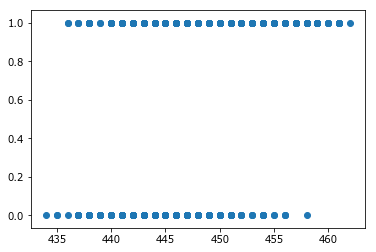

In [96]:
plt.scatter(ewq,qwe)